In [42]:
!pip install thefuzz[speedup]

In [43]:
import pandas as pd
import requests
import numpy as np
from thefuzz import fuzz, process
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import json
import re
from datetime import datetime

In [44]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [45]:
API_KEY = "your_companies_house_api_key"
API_BASE_URL = "https://api.company-information.service.gov.uk"

In [46]:
df = pd.read_csv("/content/CompanyV2 (July 2025).csv")

In [47]:
print("Initial Data Preview:")
display(df.head())

Initial Data Preview:


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,CompanyCategory,CompanyStatus,CountryOfOrigin,DissolutionDate,IncorporationDate,Accounts.AccountRefDay,Accounts.AccountRefMonth,Accounts.NextDueDate,Accounts.LastMadeUpDate,Accounts.AccountCategory,Returns.NextDueDate,Returns.LastMadeUpDate,Mortgages.NumMortCharges,Mortgages.NumMortOutstanding,Mortgages.NumMortPartSatisfied,Mortgages.NumMortSatisfied,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,LimitedPartnerships.NumGenPartners,LimitedPartnerships.NumLimPartners,URI,PreviousName_1.CONDATE,PreviousName_1.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CONDATE,PreviousName_3.CompanyName,PreviousName_4.CONDATE,PreviousName_4.CompanyName,PreviousName_5.CONDATE,PreviousName_5.CompanyName,PreviousName_6.CONDATE,PreviousName_6.CompanyName,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,BULLDOG MINI SKIPS LTD,15330909,NaN,NaN,"YARD 1, ARNOCK BUNGALOW",SOUTHEND ARTERIAL ROAD,BRENTWOOD,NaN,UNITED KINGDOM,CM13 3TB,Private Limited Company,Active,United Kingdom,NaN,06/12/2023,31.0,12.0,06/09/2025,NaN,NO ACCOUNTS FILED,03/01/2025,NaN,0,0,0,0,38110 - Collection of non-hazardous waste,43999 - Other specialised construction activit...,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15330909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19/12/2024,NaN
1,BULLDOG LIMITED,9043007,NaN,NaN,FORESTERS COTTAGE,STONEY HEATH,BASINGSTOKE,HAMPSHIRE,NaN,RG26 5SW,Private Limited Company,Active,United Kingdom,NaN,16/05/2014,31.0,3.0,31/12/2024,31/03/2023,TOTAL EXEMPTION FULL,13/06/2017,16/05/2016,0,0,0,0,68209 - Other letting and operating of own or ...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/09043007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30/05/2025,16/05/2024
2,BULLDOG MUSHROOMS LTD,8465312,NaN,NaN,C58-59 NEW COVENT GARDEN MARKET,NINE ELMS LANE,NaN,NaN,NaN,SW8 5JJ,Private Limited Company,Active,United Kingdom,NaN,28/03/2013,29.0,4.0,29/01/2025,30/04/2023,MICRO ENTITY,25/04/2017,28/03/2016,0,0,0,0,46310 - Wholesale of fruit and vegetables,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/08465312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11/04/2025,28/03/2024
3,BULLDOG MUSICAL ENTERTAINMENTS LIMITED,1652098,NaN,NaN,5 RAVENSFIELD GARDENS,STONELEIGH,SURREY,NaN,NaN,KT19 0ST,Private Limited Company,Active,United Kingdom,NaN,16/07/1982,31.0,3.0,31/12/2024,31/03/2023,MICRO ENTITY,15/01/2017,18/12/2015,0,0,0,0,90030 - Artistic creation,93290 - Other amusement and recreation activit...,NaN,NaN,0,0,http://business.data.gov.uk/id/company/01652098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/01/2025,18/12/2023
4,BULLDOG NETWORK (BOURNEMOUTH) LIMITED,4667818,NaN,NaN,"FRP ADVISORY TRADING LIMITED, MOUNTBATTEN HOUSE",GROSVENOR SQUARE,SOUTHAMPTON,NaN,NaN,SO15 2RP,Private Limited Company,Liquidation,United Kingdom,NaN,17/02/2003,31.0,3.0,31/12/2021,31/03/2020,TOTAL EXEMPTION FULL,17/03/2017,17/02/2016,2,2,0,0,47710 - Retail sale of clothing in specialised...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/04667818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,08/02/2022,25/01/2021


In [48]:
def profile_data(df):
    profile = {
        'Total Rows': len(df),
        'Total Columns': len(df.columns),
        'Missing Values': df.isnull().sum().to_dict(),
        'Data Types': df.dtypes.to_dict(),
        'Unique Values': df.nunique().to_dict(),
        'Sample Values': {col: df[col].dropna().head(3).tolist() for col in df.columns}
    }
    return profile


In [49]:
profile = profile_data(df)
print("Data Profile:")
for key, value in profile.items():
    print(f"{key}:\n{value}\n")

Data Profile:
Total Rows:
306

Total Columns:
55

Missing Values:
{'CompanyName': 0, ' CompanyNumber': 20, 'RegAddress.CareOf': 304, 'RegAddress.POBox': 302, 'RegAddress.AddressLine1': 5, ' RegAddress.AddressLine2': 119, 'RegAddress.PostTown': 57, 'RegAddress.County': 199, 'RegAddress.Country': 64, 'RegAddress.PostCode': 7, 'CompanyCategory': 0, 'CompanyStatus': 0, 'CountryOfOrigin': 13, 'DissolutionDate': 306, 'IncorporationDate': 0, 'Accounts.AccountRefDay': 4, 'Accounts.AccountRefMonth': 4, 'Accounts.NextDueDate': 6, 'Accounts.LastMadeUpDate': 84, 'Accounts.AccountCategory': 0, 'Returns.NextDueDate': 8, 'Returns.LastMadeUpDate': 205, 'Mortgages.NumMortCharges': 0, 'Mortgages.NumMortOutstanding': 0, 'Mortgages.NumMortPartSatisfied': 0, 'Mortgages.NumMortSatisfied': 0, 'SICCode.SicText_1': 0, 'SICCode.SicText_2': 259, 'SICCode.SicText_3': 285, 'SICCode.SicText_4': 293, 'LimitedPartnerships.NumGenPartners': 0, 'LimitedPartnerships.NumLimPartners': 0, 'URI': 33, 'PreviousName_1.CONDATE'

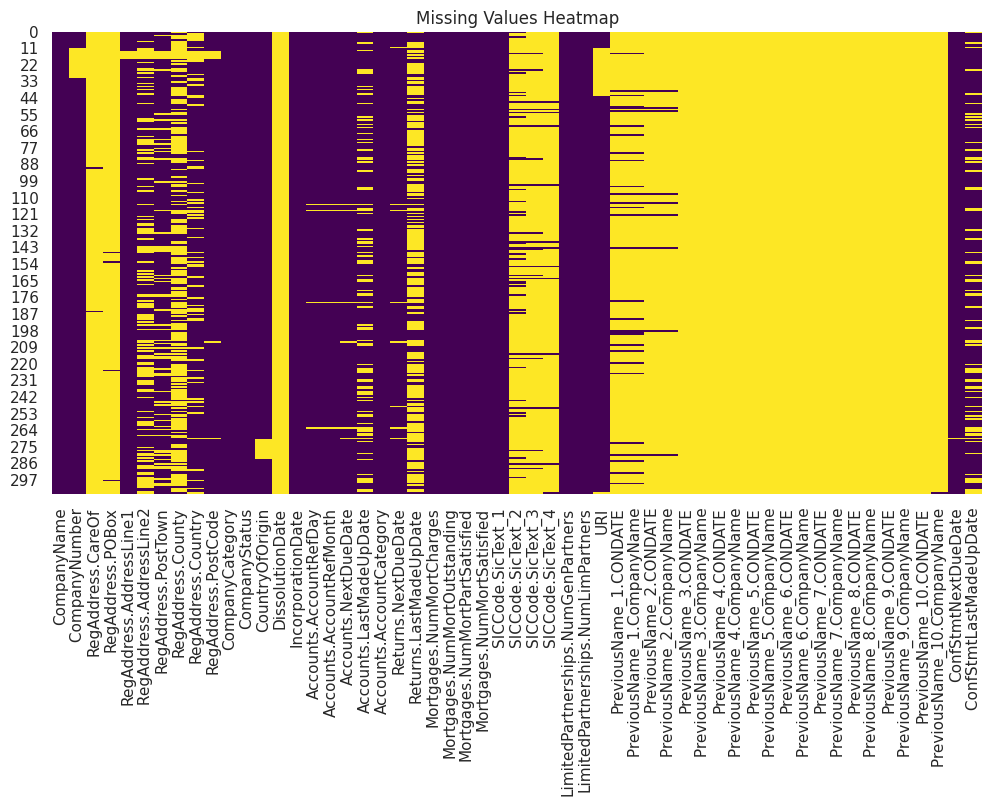

In [50]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [51]:
df.columns = df.columns.str.strip().str.replace(' ', '_')


In [52]:
def clean_data(df):
    df_clean = df.copy()


    text_columns = ['CompanyName', 'RegAddress.AddressLine1', 'RegAddress.AddressLine2',
                    'RegAddress.PostTown', 'RegAddress.County', 'RegAddress.Country']
    for col in text_columns:
        df_clean[col] = df_clean[col].astype(str).str.strip().str.title()

    df_clean.replace('null', np.nan, inplace=True)

    df_clean['RegAddress.PostCode'] = df_clean['RegAddress.PostCode'].str.replace(' ', '').str.upper()

    date_columns = ['IncorporationDate', 'Accounts.NextDueDate', 'Accounts.LastMadeUpDate',
                    'Returns.NextDueDate', 'Returns.LastMadeUpDate', 'ConfStmtNextDueDate',
                    'ConfStmtLastMadeUpDate']
    for col in date_columns:
        df_clean[col] = pd.to_datetime(df_clean[col], format='%d/%m/%Y', errors='coerce')

    numeric_columns = ['Mortgages.NumMortCharges', 'Mortgages.NumMortOutstanding',
                       'Mortgages.NumMortPartSatisfied', 'Mortgages.NumMortSatisfied',
                       'LimitedPartnerships.NumGenPartners', 'LimitedPartnerships.NumLimPartners']
    df_clean[numeric_columns] = df_clean[numeric_columns].fillna(0)

    return df_clean

df_clean = clean_data(df)
print("Cleaned Data Preview:")
display(df_clean.head())


Cleaned Data Preview:


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,CompanyCategory,CompanyStatus,CountryOfOrigin,DissolutionDate,IncorporationDate,Accounts.AccountRefDay,Accounts.AccountRefMonth,Accounts.NextDueDate,Accounts.LastMadeUpDate,Accounts.AccountCategory,Returns.NextDueDate,Returns.LastMadeUpDate,Mortgages.NumMortCharges,Mortgages.NumMortOutstanding,Mortgages.NumMortPartSatisfied,Mortgages.NumMortSatisfied,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,LimitedPartnerships.NumGenPartners,LimitedPartnerships.NumLimPartners,URI,PreviousName_1.CONDATE,PreviousName_1.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CONDATE,PreviousName_3.CompanyName,PreviousName_4.CONDATE,PreviousName_4.CompanyName,PreviousName_5.CONDATE,PreviousName_5.CompanyName,PreviousName_6.CONDATE,PreviousName_6.CompanyName,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate
0,Bulldog Mini Skips Ltd,15330909,NaN,NaN,"Yard 1, Arnock Bungalow",Southend Arterial Road,Brentwood,Nan,United Kingdom,CM133TB,Private Limited Company,Active,United Kingdom,NaN,2023-12-06,31.0,12.0,2025-09-06,NaT,NO ACCOUNTS FILED,2025-01-03,NaT,0,0,0,0,38110 - Collection of non-hazardous waste,43999 - Other specialised construction activit...,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15330909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-19,NaT
1,Bulldog Limited,9043007,NaN,NaN,Foresters Cottage,Stoney Heath,Basingstoke,Hampshire,Nan,RG265SW,Private Limited Company,Active,United Kingdom,NaN,2014-05-16,31.0,3.0,2024-12-31,2023-03-31,TOTAL EXEMPTION FULL,2017-06-13,2016-05-16,0,0,0,0,68209 - Other letting and operating of own or ...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/09043007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-30,2024-05-16
2,Bulldog Mushrooms Ltd,8465312,NaN,NaN,C58-59 New Covent Garden Market,Nine Elms Lane,Nan,Nan,Nan,SW85JJ,Private Limited Company,Active,United Kingdom,NaN,2013-03-28,29.0,4.0,2025-01-29,2023-04-30,MICRO ENTITY,2017-04-25,2016-03-28,0,0,0,0,46310 - Wholesale of fruit and vegetables,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/08465312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-04-11,2024-03-28
3,Bulldog Musical Entertainments Limited,1652098,NaN,NaN,5 Ravensfield Gardens,Stoneleigh,Surrey,Nan,Nan,KT190ST,Private Limited Company,Active,United Kingdom,NaN,1982-07-16,31.0,3.0,2024-12-31,2023-03-31,MICRO ENTITY,2017-01-15,2015-12-18,0,0,0,0,90030 - Artistic creation,93290 - Other amusement and recreation activit...,NaN,NaN,0,0,http://business.data.gov.uk/id/company/01652098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-01,2023-12-18
4,Bulldog Network (Bournemouth) Limited,4667818,NaN,NaN,"Frp Advisory Trading Limited, Mountbatten House",Grosvenor Square,Southampton,Nan,Nan,SO152RP,Private Limited Company,Liquidation,United Kingdom,NaN,2003-02-17,31.0,3.0,2021-12-31,2020-03-31,TOTAL EXEMPTION FULL,2017-03-17,2016-02-17,2,2,0,0,47710 - Retail sale of clothing in specialised...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/04667818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-02-08,2021-01-25


In [53]:
def deduplicate_data(df):

    df['unique_id'] = df.apply(lambda x: f"{x['CompanyName']}_{x['RegAddress.PostCode']}_{x['CompanyNumber']}", axis=1)

    duplicates = df.duplicated(subset=['CompanyName', 'RegAddress.PostCode'], keep=False)
    print(f"Number of duplicate records: {duplicates.sum()}")

    df_dedup = df.sort_values('IncorporationDate', ascending=False).drop_duplicates(
        subset=['CompanyName', 'RegAddress.PostCode'], keep='first')

    return df_dedup

df_dedup = deduplicate_data(df_clean)
print("Deduplicated Data Preview:")
display(df_dedup.head())

Number of duplicate records: 10
Deduplicated Data Preview:


,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,CompanyCategory,CompanyStatus,CountryOfOrigin,DissolutionDate,IncorporationDate,Accounts.AccountRefDay,Accounts.AccountRefMonth,Accounts.NextDueDate,Accounts.LastMadeUpDate,Accounts.AccountCategory,Returns.NextDueDate,Returns.LastMadeUpDate,Mortgages.NumMortCharges,Mortgages.NumMortOutstanding,Mortgages.NumMortPartSatisfied,Mortgages.NumMortSatisfied,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,LimitedPartnerships.NumGenPartners,LimitedPartnerships.NumLimPartners,URI,PreviousName_1.CONDATE,PreviousName_1.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CONDATE,PreviousName_3.CompanyName,PreviousName_4.CONDATE,PreviousName_4.CompanyName,PreviousName_5.CONDATE,PreviousName_5.CompanyName,PreviousName_6.CONDATE,PreviousName_6.CompanyName,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate,unique_id
83,Bullefx Ltd,15804108,NaN,NaN,6690 321-323 High Road,Nan,Chadwell Heath,Essex,United Kingdom,RM66AX,Private Limited Company,Active,United Kingdom,NaN,2024-06-26,30.0,6.0,2026-03-26,NaT,NO ACCOUNTS FILED,2025-07-24,NaT,0,0,0,0,62020 - Information technology consultancy act...,63990 - Other information service activities n...,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15804108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-09,NaT,Bullefx Ltd_RM66AX_15804108
171,Arkway Group Ltd,15778743,NaN,NaN,Unit 1D Howden Hall Industrial Estate,Howden Road,Silsden,West Yorkshire,United Kingdom,BD200HJ,Private Limited Company,Active,United Kingdom,NaN,2024-06-14,30.0,6.0,2026-03-14,NaT,NO ACCOUNTS FILED,2025-07-12,NaT,0,0,0,0,64203 - Activities of construction holding com...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15778743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-27,NaT,Arkway Group Ltd_BD200HJ_15778743
173,Arkway Plant Hire Ltd,15777373,NaN,NaN,Unit 1D Howden Hall Howden Road,Silsden,Keighley,Nan,England,BD200HJ,Private Limited Company,Active,United Kingdom,NaN,2024-06-13,30.0,6.0,2026-03-13,NaT,NO ACCOUNTS FILED,2025-07-11,NaT,0,0,0,0,77320 - Renting and leasing of construction an...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15777373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-26,NaT,Arkway Plant Hire Ltd_BD200HJ_15777373
231,Airlink Global Travel Limited,15733939,NaN,NaN,131 Bellegrove Road,Nan,Welling,Nan,England,DA163QS,Private Limited Company,Active,United Kingdom,NaN,2024-05-22,31.0,5.0,2026-02-22,NaT,NO ACCOUNTS FILED,2025-06-19,NaT,0,0,0,0,79110 - Travel agency activities,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15733939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-04,NaT,Airlink Global Travel Limited_DA163QS_15733939
117,Bullen No.2 Limited,15682841,NaN,NaN,9-11 Drayton High Road,Drayton,Norwich,Norfolk,United Kingdom,NR86AH,Private Limited Company,Active,United Kingdom,NaN,2024-04-26,30.0,4.0,2026-01-26,NaT,NO ACCOUNTS FILED,2025-05-24,NaT,0,0,0,0,64209 - Activities of other holding companies ...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15682841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-09,NaT,Bullen No.2 Limited_NR86AH_15682841


In [54]:
def validate_company(company_name, company_number):
    headers = {'Authorization': f'Basic {API_KEY}'}
    url = f"{API_BASE_URL}/company/{company_number}"

    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            api_company_name = data.get('company_name', '').strip().title()
            similarity = fuzz.ratio(company_name.strip().title(), api_company_name)
            return {
                'api_company_name': api_company_name,
                'status': 'Valid' if similarity > 90 else 'Mismatch',
                'similarity_score': similarity
            }
        elif response.status_code == 401:
            return {'status': 'Unauthorized - Check API Key', 'api_company_name': '', 'similarity_score': 0}
        elif response.status_code == 404:
            return {'status': 'Company Not Found', 'api_company_name': '', 'similarity_score': 0}
        elif response.status_code == 429:
            return {'status': 'Rate Limit Exceeded', 'api_company_name': '', 'similarity_score': 0}
        else:
            return {'status': f'API Error: {response.status_code}', 'api_company_name': '', 'similarity_score': 0}
    except Exception as e:
        return {'status': f'Error: {str(e)}', 'api_company_name': '', 'similarity_score': 0}


validation_results = []
for _, row in df_dedup.head(5).iterrows():

    company_number = row['CompanyNumber']
    if pd.isna(company_number) or not str(company_number).strip():
        result = {'status': 'Invalid Company Number', 'api_company_name': '', 'similarity_score': 0}
    else:
        result = validate_company(row['CompanyName'], company_number)
    validation_results.append({
        'CompanyName': row['CompanyName'],
        'CompanyNumber': row['CompanyNumber'],
        'API_CompanyName': result['api_company_name'],
        'ValidationStatus': result['status'],
        'SimilarityScore': result['similarity_score']
    })

validation_df = pd.DataFrame(validation_results)
print("Validation Results:")
display(validation_df)

Validation Results:


,CompanyName,CompanyNumber,API_CompanyName,ValidationStatus,SimilarityScore
0,Bullefx Ltd,15804108,,API Error: 400,0
1,Arkway Group Ltd,15778743,,API Error: 400,0
2,Arkway Plant Hire Ltd,15777373,,API Error: 400,0
3,Airlink Global Travel Limited,15733939,,API Error: 400,0
4,Bullen No.2 Limited,15682841,,API Error: 400,0


Enrichment API Request for 15804108: Status Code = 400
Enrichment API Request for 15778743: Status Code = 400
Enrichment API Request for 15777373: Status Code = 400
Enrichment API Request for 15733939: Status Code = 400
Enrichment API Request for 15682841: Status Code = 400
Enriched Data Columns: ['CompanyName', 'CompanyNumber', 'RegAddress.CareOf', 'RegAddress.POBox', 'RegAddress.AddressLine1', 'RegAddress.AddressLine2', 'RegAddress.PostTown', 'RegAddress.County', 'RegAddress.Country', 'RegAddress.PostCode', 'CompanyCategory', 'CompanyStatus', 'CountryOfOrigin', 'DissolutionDate', 'IncorporationDate', 'Accounts.AccountRefDay', 'Accounts.AccountRefMonth', 'Accounts.NextDueDate', 'Accounts.LastMadeUpDate', 'Accounts.AccountCategory', 'Returns.NextDueDate', 'Returns.LastMadeUpDate', 'Mortgages.NumMortCharges', 'Mortgages.NumMortOutstanding', 'Mortgages.NumMortPartSatisfied', 'Mortgages.NumMortSatisfied', 'SICCode.SicText_1', 'SICCode.SicText_2', 'SICCode.SicText_3', 'SICCode.SicText_4', 

,CompanyName,CompanyNumber,RegAddress.CareOf,RegAddress.POBox,RegAddress.AddressLine1,RegAddress.AddressLine2,RegAddress.PostTown,RegAddress.County,RegAddress.Country,RegAddress.PostCode,CompanyCategory,CompanyStatus,CountryOfOrigin,DissolutionDate,IncorporationDate,Accounts.AccountRefDay,Accounts.AccountRefMonth,Accounts.NextDueDate,Accounts.LastMadeUpDate,Accounts.AccountCategory,Returns.NextDueDate,Returns.LastMadeUpDate,Mortgages.NumMortCharges,Mortgages.NumMortOutstanding,Mortgages.NumMortPartSatisfied,Mortgages.NumMortSatisfied,SICCode.SicText_1,SICCode.SicText_2,SICCode.SicText_3,SICCode.SicText_4,LimitedPartnerships.NumGenPartners,LimitedPartnerships.NumLimPartners,URI,PreviousName_1.CONDATE,PreviousName_1.CompanyName,PreviousName_2.CONDATE,PreviousName_2.CompanyName,PreviousName_3.CONDATE,PreviousName_3.CompanyName,PreviousName_4.CONDATE,PreviousName_4.CompanyName,PreviousName_5.CONDATE,PreviousName_5.CompanyName,PreviousName_6.CONDATE,PreviousName_6.CompanyName,PreviousName_7.CONDATE,PreviousName_7.CompanyName,PreviousName_8.CONDATE,PreviousName_8.CompanyName,PreviousName_9.CONDATE,PreviousName_9.CompanyName,PreviousName_10.CONDATE,PreviousName_10.CompanyName,ConfStmtNextDueDate,ConfStmtLastMadeUpDate,unique_id,RegisteredOffice,CompanyStatusAPI,ErrorDetails
0,Bullefx Ltd,15804108,NaN,NaN,6690 321-323 High Road,Nan,Chadwell Heath,Essex,United Kingdom,RM66AX,Private Limited Company,Active,United Kingdom,NaN,2024-06-26,30.0,6.0,2026-03-26,NaT,NO ACCOUNTS FILED,2025-07-24,NaT,0,0,0,0,62020 - Information technology consultancy act...,63990 - Other information service activities n...,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15804108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-09,NaT,Bullefx Ltd_RM66AX_15804108,,,"API Error: Status Code 400, Response = {""error..."
1,Arkway Group Ltd,15778743,NaN,NaN,Unit 1D Howden Hall Industrial Estate,Howden Road,Silsden,West Yorkshire,United Kingdom,BD200HJ,Private Limited Company,Active,United Kingdom,NaN,2024-06-14,30.0,6.0,2026-03-14,NaT,NO ACCOUNTS FILED,2025-07-12,NaT,0,0,0,0,64203 - Activities of construction holding com...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15778743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-27,NaT,Arkway Group Ltd_BD200HJ_15778743,,,"API Error: Status Code 400, Response = {""error..."
2,Arkway Plant Hire Ltd,15777373,NaN,NaN,Unit 1D Howden Hall Howden Road,Silsden,Keighley,Nan,England,BD200HJ,Private Limited Company,Active,United Kingdom,NaN,2024-06-13,30.0,6.0,2026-03-13,NaT,NO ACCOUNTS FILED,2025-07-11,NaT,0,0,0,0,77320 - Renting and leasing of construction an...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15777373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-26,NaT,Arkway Plant Hire Ltd_BD200HJ_15777373,,,"API Error: Status Code 400, Response = {""error..."
3,Airlink Global Travel Limited,15733939,NaN,NaN,131 Bellegrove Road,Nan,Welling,Nan,England,DA163QS,Private Limited Company,Active,United Kingdom,NaN,2024-05-22,31.0,5.0,2026-02-22,NaT,NO ACCOUNTS FILED,2025-06-19,NaT,0,0,0,0,79110 - Travel agency activities,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15733939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-06-04,NaT,Airlink Global Travel Limited_DA163QS_15733939,,,"API Error: Status Code 400, Response = {""error..."
4,Bullen No.2 Limited,15682841,NaN,NaN,9-11 Drayton High Road,Drayton,Norwich,Norfolk,United Kingdom,NR86AH,Private Limited Company,Active,United Kingdom,NaN,2024-04-26,30.0,4.0,2026-01-26,NaT,NO ACCOUNTS FILED,2025-05-24,NaT,0,0,0,0,64209 - Activities of other holding companies ...,NaN,NaN,NaN,0,0,http://business.data.gov.uk/id/company/15682841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-09,NaT,Bullen No.2 Limited_NR86AH_15682841,,,"API Error: Status Code 400, Response = {""error..

Summary Report:
Total Records:
5

Active Companies:
0

Liquidation Companies:
0

SIC Code Distribution:
{'62020 - Information technology consultancy activities': 1, '64203 - Activities of construction holding companies': 1, '77320 - Renting and leasing of construction and civil engineering machinery and equipment': 1, '79110 - Travel agency activities': 1, '64209 - Activities of other holding companies n.e.c.': 1}

Incorporation Year Distribution:
{2024: 5}



/tmp/ipython-input-55-3535118765.py:83: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


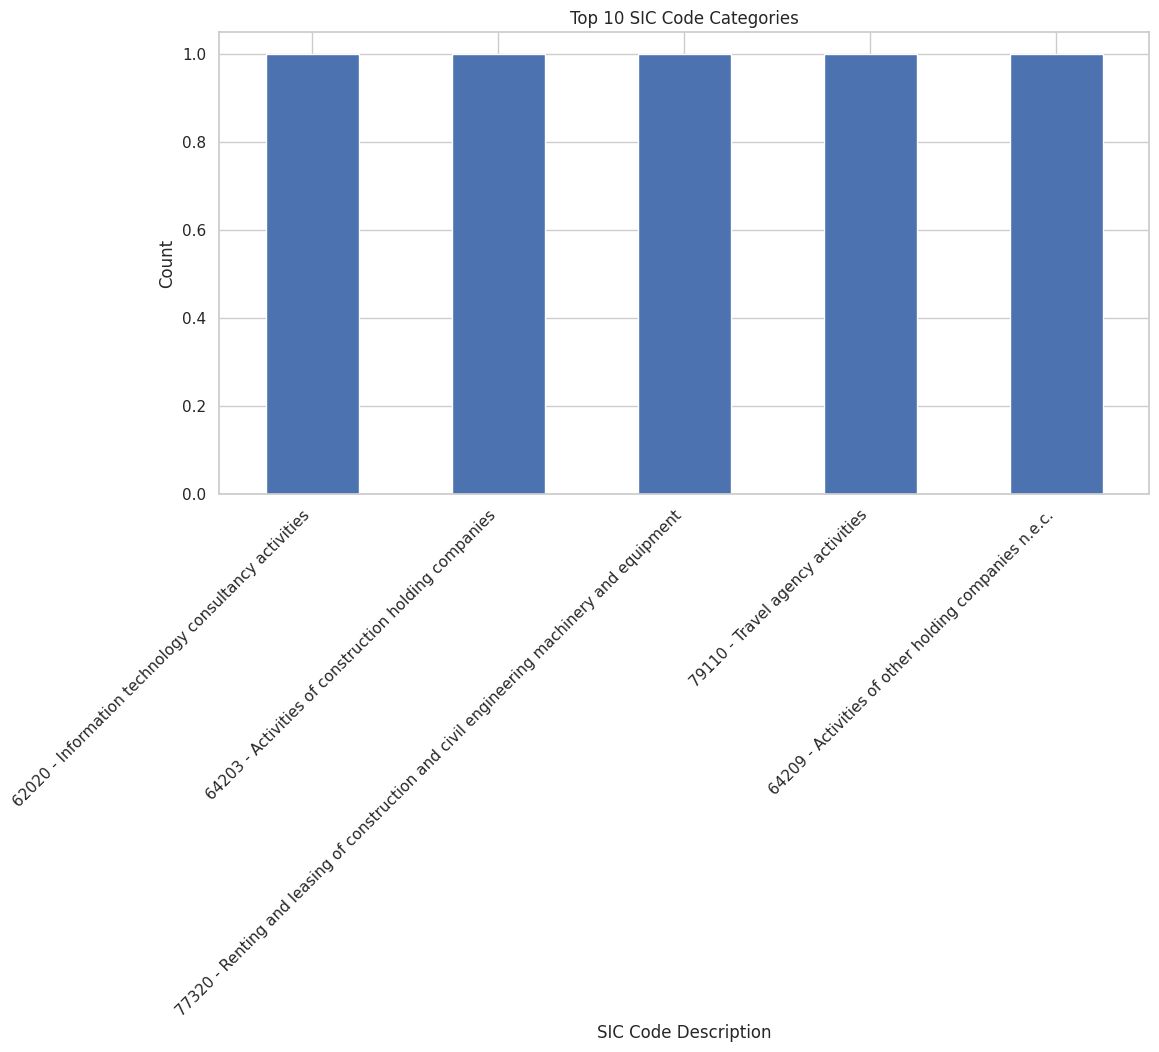

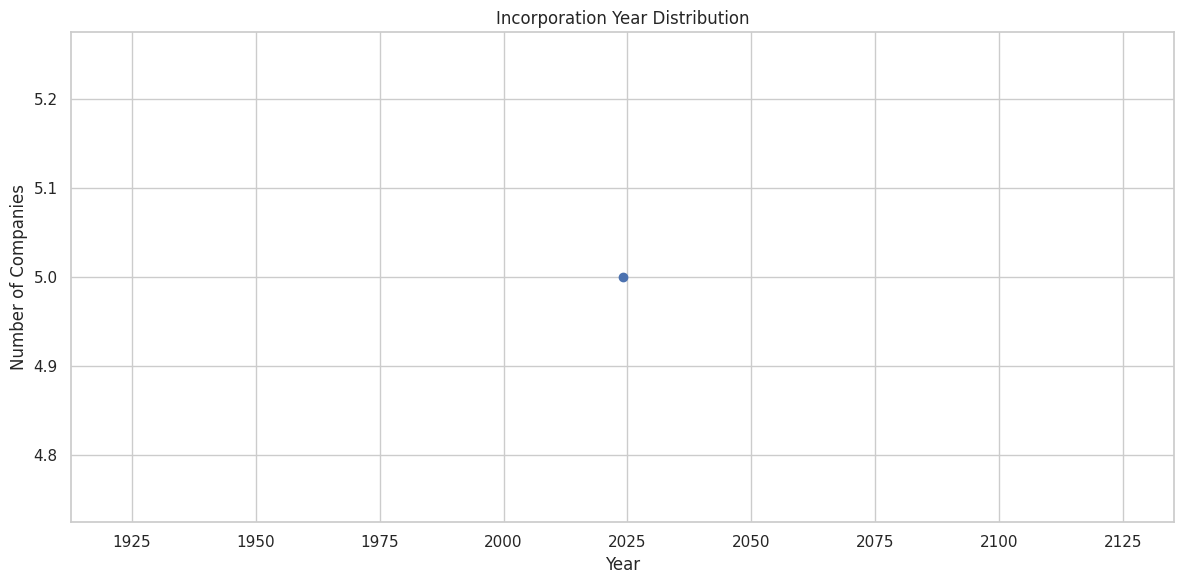

In [55]:
def enrich_data(df):
    enriched_data = []
    for _, row in df.iterrows():
        company_number = row['CompanyNumber']
        row_dict = row.to_dict()

        if pd.isna(company_number) or not str(company_number).strip():
            row_dict['CompanyStatusAPI'] = ''
            row_dict['RegisteredOffice'] = ''
            row_dict['ErrorDetails'] = 'Missing or empty company number'
            enriched_data.append(row_dict)
            continue

        headers = {'Authorization': f'Basic {API_KEY}'}
        url = f"{API_BASE_URL}/company/{company_number}"

        try:
            time.sleep(1)
            response = requests.get(url, headers=headers, timeout=10)
            print(f"Enrichment API Request for {company_number}: Status Code = {response.status_code}")

            if response.status_code == 200:
                data = response.json()
                row_dict['RegisteredOffice'] = data.get('registered_office_address', {}).get('address_line_1', '')
                row_dict['CompanyStatusAPI'] = data.get('company_status', '').title()
                row_dict['ErrorDetails'] = ''
            else:
                row_dict['RegisteredOffice'] = ''
                row_dict['CompanyStatusAPI'] = ''
                row_dict['ErrorDetails'] = f'API Error: Status Code {response.status_code}, Response = {response.text[:200]}'
        except requests.exceptions.RequestException as e:
            row_dict['RegisteredOffice'] = ''
            row_dict['CompanyStatusAPI'] = ''
            row_dict['ErrorDetails'] = f'Network Error: {str(e)}'

        enriched_data.append(row_dict)

    df_enriched = pd.DataFrame(enriched_data)
    print("Enriched Data Columns:", df_enriched.columns.tolist())
    return df_enriched

df_enriched = enrich_data(df_dedup.head(5))
print("Enriched Data Preview:")
display(df_enriched)

import matplotlib.pyplot as plt
import seaborn as sns

def generate_report(df):

    status_column = 'CompanyStatusAPI' if 'CompanyStatusAPI' in df.columns else None
    if status_column is None:
        print("Warning: CompanyStatusAPI column not found in dataset. Skipping status-related metrics.")
        active_count = 0
        liquidation_count = 0
    else:
        active_count = len(df[df[status_column] == 'Active'])
        liquidation_count = len(df[df[status_column] == 'Liquidation'])

    report = {
        'Total Records': len(df),
        'Active Companies': active_count,
        'Liquidation Companies': liquidation_count,
        'SIC Code Distribution': df['SICCode.SicText_1'].value_counts().head(10).to_dict() if 'SICCode.SicText_1' in df.columns else {},
        'Incorporation Year Distribution': pd.to_datetime(
            df['IncorporationDate'], errors='coerce').dt.year.value_counts().sort_index().to_dict() if 'IncorporationDate' in df.columns else {}
    }
    return report

report = generate_report(df_enriched)
print("Summary Report:")
for key, value in report.items():
    print(f"{key}:\n{value}\n")

if 'SICCode.SicText_1' in df_enriched.columns:
    sic_counts = df_enriched['SICCode.SicText_1'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    sic_counts.plot(kind='bar')
    plt.title('Top 10 SIC Code Categories')
    plt.xlabel('SIC Code Description')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Warning: SICCode.SicText_1 column not found. Skipping SIC code visualization.")

if 'IncorporationDate' in df_enriched.columns:
    inc_years = pd.to_datetime(df_enriched['IncorporationDate'], errors='coerce').dt.year.value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    inc_years.plot(kind='line', marker='o')
    plt.title('Incorporation Year Distribution')
    plt.xlabel('Year')
    plt.ylabel('Number of Companies')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Warning: IncorporationDate column not found. Skipping incorporation year visualization.")
